<a href="https://colab.research.google.com/github/nagahara-masaaki/IEICECS2023/blob/main/IEICE_CS.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Compressed sensing example with CVXPY

Reconstruction error: 3.305329665580967e-10


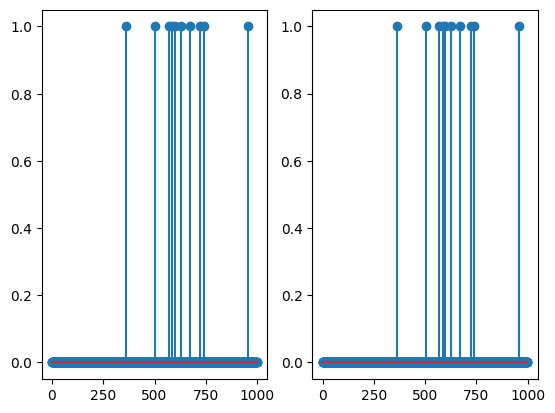

In [8]:
import numpy as np
import cvxpy as cp
import matplotlib.pyplot as plt

# random seed
np.random.seed(1)

# Problem size
n = 1000
m = 100

# random measurement matrix
A = np.random.randn(m, n)

# sparse vector (n-dimensional, s-sparse)
s = 10
x_orig = np.zeros(n)
S = np.random.randint(n,size=s)
x_orig[S] = 1

# observation vector
b = A @ x_orig

# optimization by cvxpy
x = cp.Variable(n)
objective = cp.Minimize(cp.norm(x, 1))
constraints = [A @ x == b]
prob = cp.Problem(objective, constraints)
result = prob.solve()

# reconstructed vector
fig = plt.figure()
ax1 = fig.add_subplot(1, 2, 1)
ax1.stem(x_orig)
ax2 = fig.add_subplot(1, 2, 2)
ax2.stem(x.value)
plt.savefig("cvxpy_result.png", format="png", dpi=300)

# reconstruction error
error = np.linalg.norm(x_orig - x.value)
print('Reconstruction error:', error)


# Group Testing

(array([ 37,  72, 235, 767, 908]),)
(array([ 37,  72, 235, 767, 908]),)


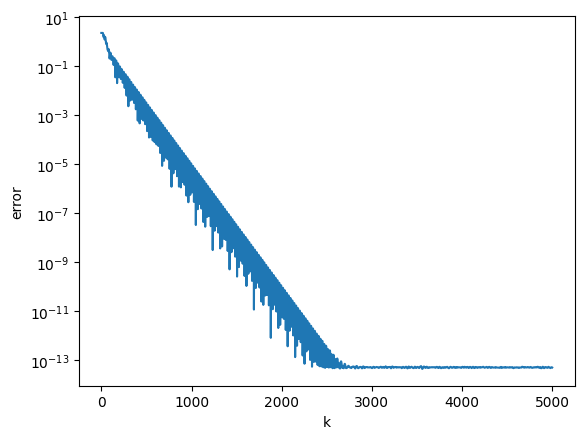

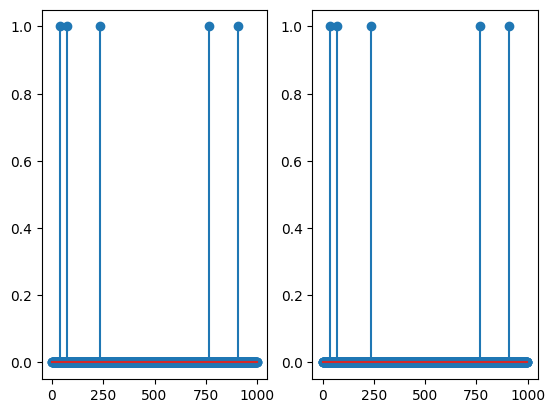

In [9]:
import cvxpy as cp
import numpy as np
import matplotlib.pyplot as plt

## Parameter settings
# vector size (number of individuals)
n = 1000
# number of positives
s = 5
# random seed
np.random.seed(1)

# original vector (n-dimensional, s-sparse)
x_orig = np.zeros(n)
S = np.random.randint(n,size=s)
x_orig[S] = 1

# number of tests
m = 40 # ~ k log (n/k)

# measurement matrix
A = np.random.randint(2,size=(m, n))

# observation vector
b = A @ x_orig

## Optimization by Douglas-Rachford splitting
# Soft-thresholding function
def St(lmbd, v):
  Sv = np.sign(v) * np.maximum(np.abs(v) - lmbd, 0)
  return Sv


# Parameter setting
gamma = 1 # step size
max_itr = 5000 # number of iterations
x = np.zeros(n) # initial guess

Ap = np.linalg.pinv(A) # pseudo inverse of A
M = np.eye(n) - Ap @ A
v = Ap @ b

error = np.zeros(max_itr) # residual
z = x # variable z
# Iteration
for k in range(max_itr):
  error[k] = np.linalg.norm(x_orig - x)
  x = St(gamma,z)
  z = z + M @ (2*x - z) + v - x

## Error analysis
fig = plt.figure()
plt.semilogy(error)
plt.xlabel("k")
plt.ylabel("error")
plt.savefig("group_testing_error.png", format="png", dpi=300)

## Reconstructed vector
fig = plt.figure()
ax1 = fig.add_subplot(1, 2, 1)
ax1.stem(x_orig)
ax2 = fig.add_subplot(1, 2, 2)
#x_est=np.trunc(x*1000)/1000
ax2.stem(x)
plt.savefig("group_testing_result.png", format="png", dpi=300)

## Reconstruction result
print(np.nonzero(x_orig))
x_est=np.round(x)
print(x_est.nonzero())


# System Identification

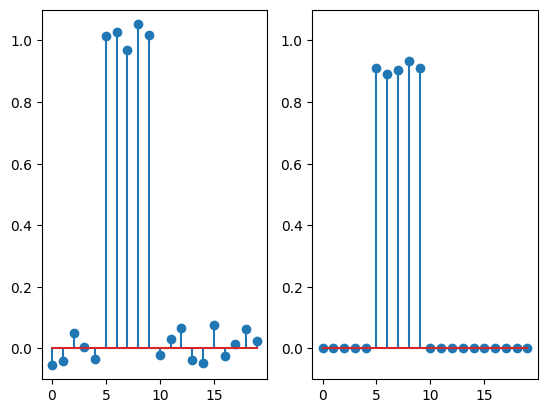

In [10]:
import numpy as np
from scipy.linalg import toeplitz
from numpy.linalg import inv
import matplotlib.pyplot as plt

# input u
np.random.seed(0)
N = 100
u = np.random.rand(N)
u = np.where(u >= 0.5, 1, -1)

# true impulse response g*
m = 20
gstar = np.zeros([m,1])
gstar[5:10] = 1

# output y
sigma2 = 0.1 # noise sd
y = np.convolve(gstar.ravel(), u.ravel(), mode='full')[:N] + np.sqrt(sigma2)*np.random.randn(N)

# Toeplitz matrix U
U = toeplitz(np.concatenate(([u[0]], np.zeros(m - 1))), u).T

# TC Kernel 
T1 = np.ones((m, 1)) * np.arange(1, m+1)
TCbeta = 100
TCalpha = 0.9
K = TCbeta * TCalpha**(np.maximum(T1, T1.T))
K = np.diag(np.diag(K))

# Kernel Regularization
lmbd = 1
g2 = K @ (inv(U.T @ U @ K + lmbd * np.eye(m)) @ U.T @ y)

# Sparse Regularization
Q = inv(K)
alpha = 0.8
lmbd = 50
if alpha > 0:
    tU = np.vstack((U, np.linalg.cholesky(lmbd * alpha * Q)))
    ty = np.vstack((y.reshape(-1,1), np.zeros((m, 1))))
    tlambda = lmbd * (1 - alpha)
elif alpha == 0:
    tU = U
    ty = y
    tlambda = lmbd
else:
    print('alpha should be in [0,1]')
    exit()

# Soft-thresholding function
def St(lmbd, v):
  Sv = np.sign(v) * np.maximum(np.abs(v) - lmbd, 0)
  return Sv

# Proximal gradient algorithm
gamma = 0.01
g = np.zeros((m, 1))
for k in range(1000):
    g = St(gamma*tlambda,g + gamma * tU.T @ (ty - tU @ g))

# Plot the results
fig = plt.figure()
ax1 = fig.add_subplot(1, 2, 1)
ax1.stem(g2)
ax1.set_ylim([-0.1,1.1]) 
ax2 = fig.add_subplot(1, 2, 2)
ax2.stem(g)
ax2.set_ylim([-0.1,1.1]) 
plt.savefig("sysid_result.png", format="png", dpi=300)


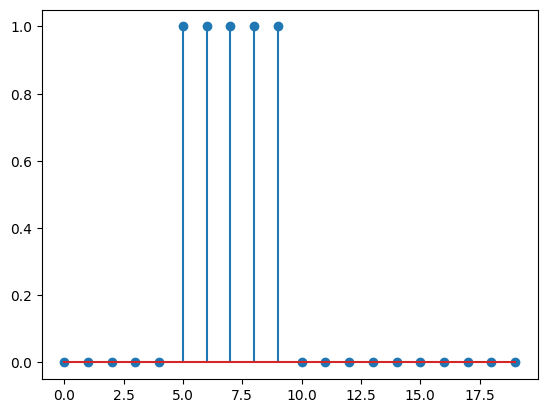

In [11]:
# Plot the original impulse response
plt.stem(gstar)
plt.savefig("sysid_original.png", format="png", dpi=300)

# Sparse Feedback Gain

In [12]:
!pip install cvxpy

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [13]:
# Import packages.
import cvxpy as cp
import numpy as np

# System matrices
n = 5
m = 3
A = np.matrix(
  [[0,0,1.1320,0,-1],
   [0,-0.0538,-0.1712,0,0.0705],
   [0,0,0,1,0],
   [0,0.0485,0,-0.8556,-1.0130],
   [0,-0.2909,0,1.0532,-0.6859]]
   )
B = np.matrix(
    [[0,0,0],
     [-0.12,1,0],
     [0,0,0],
     [4.419,0,-1.6650],
     [1.575,0,-0.0732]])

# LMIs
epsil = 0.01
eI = epsil * np.eye(n)
P = cp.Variable((n,n), symmetric=True)
Y = cp.Variable((m,n))
objective = cp.Minimize(cp.norm1(Y))
constraints = [P - eI >> 0]
constraints += [A @ P + P @ A.T + B @ Y + Y.T @ B.T + eI << 0]

# Optimization
prob = cp.Problem(objective, constraints)
prob.solve()
Y_ = Y.value
Y_[np.abs(Y_) < 1e-6] = 0

# Print result.
print("The optimal value is", prob.value)
print("A solution Y is")
print(Y_)

The optimal value is 0.005529170689678172
A solution Y is
[[ 0.          0.          0.          0.          0.        ]
 [ 0.         -0.00552915  0.          0.          0.        ]
 [ 0.          0.          0.          0.          0.        ]]
